In [30]:
from omnibelt import toposort
from itertools import product
# import pyperclip
import clipboard
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork

In [58]:
graph_generation_prompt1 = '''We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment and outcome variable) and no causal parents
- mediator variables may or may not be observable, and should always have at least one causal parents (for example, a treatment variable) and at least one causal child (for example, the outcome variable)
- collider variables may or may not be observable, and should always have at least two causal parents (for example, a treatment and outcome variable) and no causal children

Answer concisely and precisely in the desired format. Carefully complete each of these tasks in order.

1. Write a short description of what the article is about and what causal model make inform the reasoning behind an argument the might make.
2. Propose 1 outcome variable that the news article is either implicitly or explicitly addressing that people are most likely to be interested in studying, especially if people tend to have misconceptions about it
3. Propose 2 treatment variables that either directly or indirectly affect the selected outcome variable and are the most interesting to study
4. Propose 3 confounder variables that affect some reasonable combination of the outcome and treatment variables
5. Propose 3 mediator variables that affect and are affected by some reasonable combination of any other variables
6. Propose 2 collider variables that are affected by some reasonable combination of any other variables

Here is the beginning of the new article:
```
{article}
```

The variables and causal graph should, where possible, use specific details such as names and locations mentioned in the article. Also, generally the variable value "0" should correspond to the negative or control while the value "1" should correspond to the positive or greater value.

Take a deep breath and think step-by-step about how you will do this.'''

graph_generation_prompt2 = '''1. From all proposed confounder, mediator, and collider variables, select between 3-5 variables that are most interesting to study and together with the treatment and outcome variables result in a realistic interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than 3 parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a python list of the names of the parents of the variable (make sure they match the corresponding `name` field of the parent nodes)

Take a deep breath and think step-by-step about how you will do this.'''

prob_generation_prompt1 = '''We have a causal bayes net based on the following article:

```
{article}
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

{questions}

For each question above, answer with the lower and upper bound estimates of the probabilities as a python dictionary where the key corresponds to the question index in exactly the following format:

```python
probabilities = {{
  1: [0.3, 0.4],
  ...
}}
```

Answer concisely and precisely in the desired format.'''#.replace('{', '{{').replace('}', '}}')

In [183]:
article = '''
Title: Polish science. Regulations stifle innovation. And we could be a giant! - Wprost.pl
Description: Nothing came of the breakthrough method of graphene production in Poland. The blue laser technology developed by Poles was not invested in and others took over the leadership. These are just two examples of wasted inventions from Poland. About what should…
Original Language: Polish
'''[1:-1]
print(article)

Title: Polish science. Regulations stifle innovation. And we could be a giant! - Wprost.pl
Description: Nothing came of the breakthrough method of graphene production in Poland. The blue laser technology developed by Poles was not invested in and others took over the leadership. These are just two examples of wasted inventions from Poland. About what should…
Original Language: Polish


In [184]:
prompt = graph_generation_prompt1.format(article=article)
# clipboard.copy(prompt);
print(prompt)

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment

In [174]:
print(graph_generation_prompt2)

1. From all proposed confounder, mediator, and collider variables, select between 3-5 variables that are most interesting to study and together with the treatment and outcome variables result in a realistic interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than 3 parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `pa

In [185]:

nodes = [
    {
        "name": "Government Regulations",
        "description": "The level of government regulatory control over innovation",
        "type": "treatment",
        "observed": True,
        "values": ["Lax or supportive regulations", "Strict or stifling regulations"],
        "parents": []
    },
    {
        "name": "Investment in Technology",
        "description": "The amount of investment directed towards new technologies",
        "type": "treatment",
        "observed": True,
        "values": ["Low or no investment", "High investment"],
        "parents": []
    },
    {
        "name": "Innovation Success in Poland",
        "description": "The success of innovations being developed and commercialized in Poland",
        "type": "outcome",
        "observed": True,
        "values": ["Innovation is not successful", "Innovation is successful"],
        "parents": ["Government Regulations", "Investment in Technology", "Research and Development Capability", "Economic Climate"]
    },
    {
        "name": "Research and Development Capability",
        "description": "The capability for research and development in Poland",
        "type": "mediator",
        "observed": False,
        "values": ["Low R&D capability", "High R&D capability"],
        "parents": ["Investment in Technology"]
    },
    {
        "name": "Economic Climate",
        "description": "The overall economic environment in Poland",
        "type": "confounder",
        "observed": False,
        "values": ["Unfavorable economic climate", "Favorable economic climate"],
        "parents": []
    }
]




In [186]:
varvals = {node['name']: node['values'] for node in nodes}
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
print(varorder)

['Government Regulations', 'Investment in Technology', 'Research and Development Capability', 'Economic Climate', 'Innovation Success in Poland']


In [187]:

template = '{index}. What is the probability that {outcome}{parents}?'
# val_template = '{name} = {val}'
# parentval_template = val_template
# parent_template = ' given that ({parents})'
# separator = ') and ('

template = '{index}. What is the probability that {outcome}{parents}?'
val_template = '"{name}" is "{val}" (rather than "{otherval}")'
parentval_template = '"{name}" is "{val}"'
parent_template = ' given that {parents}'
separator = ' and '

template = '{index}. {parents}what is the probability that {outcome}?'
val_template = '"{name}" is "{val}" (rather than "{otherval}")'
parentval_template = '"{name}" is "{val}"'
parent_template = 'when {parents}: '
separator = ' and '

In [188]:
def generate_terms(nodes):
    index = 1
    for node in nodes:
        name = node['name']
        parents = node['parents']
        vals = node['values']
        
        for parentvals in product(*[varvals[parent] for parent in parents]):
            yield template.format(
                index=index,
                outcome=val_template.format(name=name, val=vals[1], otherval=vals[0]),
                parents=parent_template.format(parents=separator.join([parentval_template.format(name=parent, val=parentval) for parent, parentval in zip(parents, parentvals)])) if len(parents) else ''
            )
            index += 1
terms = list(generate_terms(nodes))
lines = terms.copy()
lines.append('')
lines.append('Where the variables are defined as:')
lines.extend(f'{node["name"]!r} means {node["description"]}' for node in nodes)
graph_info = '\n'.join(lines)
print(prob_generation_prompt1.format(article=article, questions=graph_info))

We have a causal bayes net based on the following article:

```
Title: Polish science. Regulations stifle innovation. And we could be a giant! - Wprost.pl
Description: Nothing came of the breakthrough method of graphene production in Poland. The blue laser technology developed by Poles was not invested in and others took over the leadership. These are just two examples of wasted inventions from Poland. About what should…
Original Language: Polish
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Government Regulations" is "Strict or stifling regulations" (rather than "Lax or supportive regulations")?
2. what is the probability that "Investment in Technology" is "High investment" (rather than "Low or no investment")?
3. when "Investment in Technology" is "Low or no investment": what is the probability that "Research and Development Capability" is "High R&D capa

In [189]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items())]
    return torch.tensor(raw)
# raw_prob_samples.append(to_prob_range(probabilities))
##################################################################################################################

probabilities = {
    1: [0.7, 0.8],  # High probability of strict regulations given the context of stifled innovation
    2: [0.4, 0.5],  # Moderate probability of high investment in technology
    3: [0.1, 0.2],  # Low probability of high R&D capability with low investment in technology
    4: [0.7, 0.8],  # High probability of high R&D capability with high investment in technology
    5: [0.5, 0.6],  # Moderate probability of a favorable economic climate
    6: [0.1, 0.2],  # Low probability of innovation success under all unfavorable conditions
    7: [0.2, 0.3],  # Slightly higher probability of success with a favorable economic climate
    8: [0.3, 0.4],  # Moderate probability of success with high R&D capability despite other unfavorable conditions
    9: [0.4, 0.5],  # Higher probability of success with favorable economic climate and high R&D capability
    10: [0.3, 0.4], # Moderate probability of success with high investment but other factors being unfavorable
    11: [0.4, 0.5], # Higher probability of success with favorable economic climate
    12: [0.5, 0.6], # Higher probability of success with high investment and R&D capability despite unfavorable economic climate
    13: [0.7, 0.8], # High probability of success with all favorable conditions except for low R&D capability
    14: [0.1, 0.2], # Low probability of success with strict regulations and other unfavorable conditions
    15: [0.2, 0.3], # Slightly higher probability of success with favorable economic climate
    16: [0.2, 0.3], # Slightly higher probability of success with high R&D capability despite other unfavorable conditions
    17: [0.3, 0.4], # Moderate probability of success with favorable economic climate and high R&D capability
    18: [0.2, 0.3], # Low probability of success with strict regulations despite high investment
    19: [0.3, 0.4], # Moderate probability of success with favorable economic climate despite strict regulations
    20: [0.4, 0.5], # Moderate probability of success with high investment and R&D capability despite strict regulations
    21: [0.6, 0.7]  # High probability of success with all favorable conditions except for strict regulations
}



raw_prob_samples.append(to_prob_range(probabilities))
##################################################################################################################
prob_range_samples = torch.stack(raw_prob_samples, )
# prob_range_samples.shape
if len(prob_range_samples.shape) == 2:
    prob_range_samples = prob_range_samples.unsqueeze(0)
else:
    union = prob_range_samples[..., 1].max(dim=0).values.sub(prob_range_samples[..., 0].min(dim=0).values).sum()
    intersection = prob_range_samples[..., 1].min(dim=0).values.sub(prob_range_samples[..., 0].max(dim=0).values).clamp_min(0).sum()
    overlap = intersection / union
    overlap.item()

In [190]:
prob_ranges = prob_range_samples.mean(dim=0)
prob_ranges = torch.tensor(prob_ranges)
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in nodes:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
# net
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome):
    def ate_fn():
        return net.ate(treatment)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn

treatment1, treatment2 = [node['name'] for node in nodes if node['type'] == 'treatment']
t1vals = [node['values'] for node in nodes if node['name'] == treatment1][0]
t2vals = [node['values'] for node in nodes if node['name'] == treatment2][0]
outcome = [node['name'] for node in nodes if node['type'] == 'outcome'][0]
ovals = [node['values'] for node in nodes if node['name'] == outcome][0]

print(tabulate([
    [treatment1, *t1vals],
    [treatment2, *t2vals],
    [outcome, *ovals]
]))

ate1, ate2, corr1, corr2 = mc_samples(100, make_ate_fn(treatment1, outcome), make_ate_fn(treatment2, outcome), make_corr_fn(treatment1, outcome), make_corr_fn(treatment2, outcome)).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in nodes))
print(tabulate([
    [f'{t1vals[1]}', f'{treatment1}', f'{ovals[1]}', f'{outcome}', ate1.mean(), corr1.mean(),],
    [f'{t2vals[1]}', f'{treatment2}', f'{ovals[1]}', f'{outcome}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

----------------------------  -----------------------------  ------------------------------
Government Regulations        Lax or supportive regulations  Strict or stifling regulations
Investment in Technology      Low or no investment           High investment
Innovation Success in Poland  Innovation is not successful   Innovation is successful
----------------------------  -----------------------------  ------------------------------


/tmp/ipykernel_3529522/256519617.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_ranges = torch.tensor(prob_ranges)


  0%|          | 0/100 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Government Regulations' means The level of government regulatory control over innovation
'Investment in Technology' means The amount of investment directed towards new technologies
'Research and Development Capability' means The capability for research and development in Poland
'Economic Climate' means The overall economic environment in Poland
'Innovation Success in Poland' means The success of innovations being developed and commercialized in Poland
Treatment Value                 Treatment                 Outcome Value             Outcome                             ATE    Correlation
------------------------------  ------------------------  ------------------------  ----------------------------  ---------  -------------
Strict or stifling regulations  Government Regulations    Innovation is successful  Innovation Success in Poland  -0.068958     -0.0461609
High investment                 Investment in Technology  Innovation is successful  Innovation Success in Poland   0.298469   

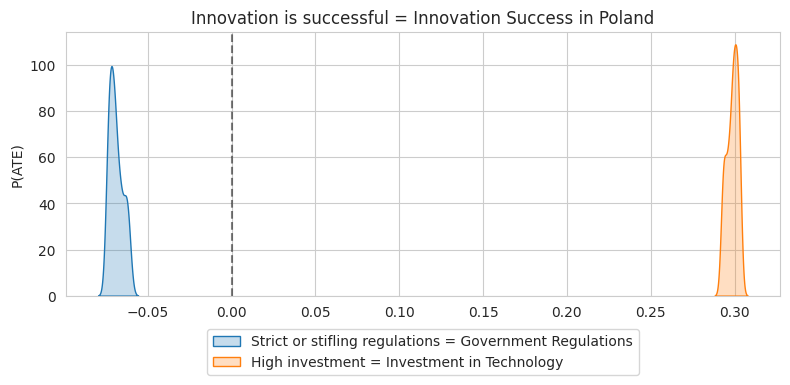

In [191]:
plt.figure(figsize=(8, 4))

sns.kdeplot(ate1, label=f'{t1vals[1]} = {treatment1}', fill=True);
sns.kdeplot(ate2, label=f'{t2vals[1]} = {treatment2}', fill=True);
plt.title(f'{ovals[1]} = {outcome}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

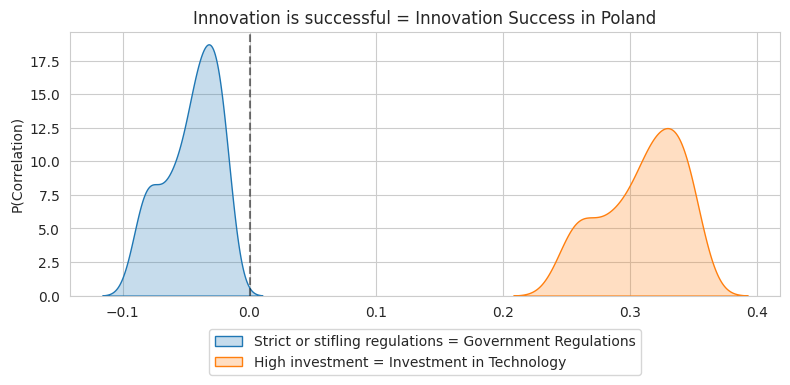

In [192]:
plt.figure(figsize=(8, 4))

sns.kdeplot(corr1, label=f'{t1vals[1]} = {treatment1}', fill=True);
sns.kdeplot(corr2, label=f'{t2vals[1]} = {treatment2}', fill=True);
plt.title(f'{ovals[1]} = {outcome}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

In [ ]:
article = '''
Title: Vacation plans are falling apart - Hello!
Description: Shops will be closed in Greece today, less than a week since they reopened, and plans to reopen high schools have been postponed indefinitely, due to a sharp increase in the number of new cases of the corona virus.
Original Language: Serbian
'''[1:-1]
probabilities = {
    1: [0.8, 0.9],  # High probability of a surge in cases, given the article context
    2: [0.05, 0.1],  # Low probability of strict measures if there's no surge in cases
    3: [0.7, 0.9],  # High probability of strict measures if there's a surge in cases
    4: [0.4, 0.6],  # Moderate probability of high compliance if there's no surge
    5: [0.6, 0.8],  # Higher probability of high compliance if there's a surge in cases
    6: [0.3, 0.5],  # Moderate probability of high economic impact without strict measures
    7: [0.5, 0.7],  # Higher probability of high economic impact with strict measures
    8: [0.2, 0.4],  # Lower probability of disrupted vacation plans under these conditions
    9: [0.3, 0.5],  # Moderate probability of disrupted plans with high economic impact
    10: [0.1, 0.3],  # Lower probability of disrupted plans with high compliance and low economic impact
    11: [0.2, 0.4],  # Slightly higher probability of disrupted plans with high economic impact
    12: [0.7, 0.9],  # High probability of disrupted plans with strict measures and low compliance
    13: [0.8, 0.9],  # Very high probability of disrupted plans under these conditions
    14: [0.6, 0.8],  # High probability of disrupted plans even with high compliance if strict measures are in place
    15: [0.7, 0.85]  # High probability of disrupted plans in this scenario
}
nodes = [
    {
        'name': 'COVID-19 Case Surge',
        'description': 'Whether there is a significant increase in COVID-19 cases in Greece.',
        'type': 'treatment',
        'observed': True,
        'values': ['No surge', 'Surge in cases'],
        'parents': []
    },
    {
        'name': 'Government Response',
        'description': 'Government response to the COVID-19 case surge, such as imposing restrictions.',
        'type': 'treatment',
        'observed': True,
        'values': ['No stringent measures', 'Strict measures like shop closures'],
        'parents': ['COVID-19 Case Surge']
    },
    {
        'name': 'Impact on Vacation Plans',
        'description': 'Whether the increase in COVID-19 cases has led to a disruption in vacation plans.',
        'type': 'outcome',
        'observed': True,
        'values': ['No impact', 'Plans disrupted'],
        'parents': ['Government Response', 'Public Compliance with Health Guidelines', 'Economic Impact']
    },
    {
        'name': 'Public Compliance with Health Guidelines',
        'description': 'Degree to which the public adheres to health guidelines and restrictions.',
        'type': 'confounder',
        'observed': True,
        'values': ['Low compliance', 'High compliance'],
        'parents': ['COVID-19 Case Surge']
    },
    {
        'name': 'Economic Impact',
        'description': 'Economic consequences of government measures on businesses and the economy.',
        'type': 'mediator',
        'observed': True,
        'values': ['Low impact', 'High impact'],
        'parents': ['Government Response']
    }
]
article = '''
Title: Polish science. Regulations stifle innovation. And we could be a giant! - Wprost.pl
Description: Nothing came of the breakthrough method of graphene production in Poland. The blue laser technology developed by Poles was not invested in and others took over the leadership. These are just two examples of wasted inventions from Poland. About what should…
Original Language: Polish
'''[1:-1]
nodes = [
    {
        "name": "Government Regulations",
        "description": "The level of government regulatory control over innovation",
        "type": "treatment",
        "observed": True,
        "values": ["Lax or supportive regulations", "Strict or stifling regulations"],
        "parents": []
    },
    {
        "name": "Investment in Technology",
        "description": "The amount of investment directed towards new technologies",
        "type": "treatment",
        "observed": True,
        "values": ["Low or no investment", "High investment"],
        "parents": []
    },
    {
        "name": "Innovation Success in Poland",
        "description": "The success of innovations being developed and commercialized in Poland",
        "type": "outcome",
        "observed": True,
        "values": ["Innovation is not successful", "Innovation is successful"],
        "parents": ["Government Regulations", "Investment in Technology", "Research and Development Capability", "Economic Climate"]
    },
    {
        "name": "Research and Development Capability",
        "description": "The capability for research and development in Poland",
        "type": "mediator",
        "observed": False,
        "values": ["Low R&D capability", "High R&D capability"],
        "parents": ["Investment in Technology"]
    },
    {
        "name": "Economic Climate",
        "description": "The overall economic environment in Poland",
        "type": "confounder",
        "observed": False,
        "values": ["Unfavorable economic climate", "Favorable economic climate"],
        "parents": []
    }
]
probabilities = {
    1: [0.7, 0.8],  # High probability of strict regulations given the context of stifled innovation
    2: [0.4, 0.5],  # Moderate probability of high investment in technology
    3: [0.1, 0.2],  # Low probability of high R&D capability with low investment in technology
    4: [0.7, 0.8],  # High probability of high R&D capability with high investment in technology
    5: [0.5, 0.6],  # Moderate probability of a favorable economic climate
    6: [0.1, 0.2],  # Low probability of innovation success under all unfavorable conditions
    7: [0.2, 0.3],  # Slightly higher probability of success with a favorable economic climate
    8: [0.3, 0.4],  # Moderate probability of success with high R&D capability despite other unfavorable conditions
    9: [0.4, 0.5],  # Higher probability of success with favorable economic climate and high R&D capability
    10: [0.3, 0.4], # Moderate probability of success with high investment but other factors being unfavorable
    11: [0.4, 0.5], # Higher probability of success with favorable economic climate
    12: [0.5, 0.6], # Higher probability of success with high investment and R&D capability despite unfavorable economic climate
    13: [0.7, 0.8], # High probability of success with all favorable conditions except for low R&D capability
    14: [0.1, 0.2], # Low probability of success with strict regulations and other unfavorable conditions
    15: [0.2, 0.3], # Slightly higher probability of success with favorable economic climate
    16: [0.2, 0.3], # Slightly higher probability of success with high R&D capability despite other unfavorable conditions
    17: [0.3, 0.4], # Moderate probability of success with favorable economic climate and high R&D capability
    18: [0.2, 0.3], # Low probability of success with strict regulations despite high investment
    19: [0.3, 0.4], # Moderate probability of success with favorable economic climate despite strict regulations
    20: [0.4, 0.5], # Moderate probability of success with high investment and R&D capability despite strict regulations
    21: [0.6, 0.7]  # High probability of success with all favorable conditions except for strict regulations
}

In [ ]:

nodes = [
    {"name": "Public Trust in Digital Currency",
     "description": "Public's confidence in the safety, reliability, and utility of the digital currency",
     "type": "outcome",
     "observed": True,
     "values": ["High Trust", "Low Trust"],
     "parents": ["Development of Digital Currency by the Federal Reserve", 
                 "Government Policy on Digital Currency", 
                 "Media Coverage of Digital Currency"]},

    {"name": "Development of Digital Currency by the Federal Reserve",
     "description": "Whether the Federal Reserve develops a digital currency",
     "type": "treatment",
     "observed": True,
     "values": ["Developed", "Not Developed"],
     "parents": ["Economic Stability"]},

    {"name": "Government Policy on Digital Currency",
     "description": "Government's stance on digital currency",
     "type": "treatment",
     "observed": True,
     "values": ["Favorable", "Unfavorable"],
     "parents": ["Economic Stability"]},

    {"name": "Economic Stability",
     "description": "The current state of economic stability",
     "type": "confounder",
     "observed": True,
     "values": ["Stable", "Unstable"],
     "parents": []},

    {"name": "Media Coverage of Digital Currency",
     "description": "The nature of media coverage regarding digital currency",
     "type": "mediator",
     "observed": True,
     "values": ["Positive", "Negative"],
     "parents": ["Economic Stability"]},

    {"name": "Investment in Digital Currency Technologies",
     "description": "Level of investment in technologies related to digital currency",
     "type": "collider",
     "observed": True,
     "values": ["Increased", "Decreased"],
     "parents": ["Development of Digital Currency by the Federal Reserve", 
                 "Government Policy on Digital Currency"]}
]
probabilities = {
    1: [0.4, 0.6],  # Economic instability can be a significant factor, especially in the context of developing new technologies like digital currency.
    2: [0.1, 0.3],  # If the economy is stable, it seems less likely that there would be a strong push to develop a new digital currency.
    3: [0.5, 0.7],  # Economic instability might increase the likelihood of developing a digital currency as a solution or alternative.
    4: [0.2, 0.4],  # With economic stability, government policy might be more conservative or unfavorable towards radical changes like digital currencies.
    5: [0.6, 0.8],  # Economic instability could lead to more unfavorable government policies as they might perceive new financial technologies as risky.
    6: [0.3, 0.5],  # Stable economic conditions could lead to either positive or slightly negative media coverage, as the need for change is not urgent.
    7: [0.6, 0.8],  # In times of economic instability, media coverage might lean towards the negative due to perceived risks or uncertainties.
    8: [0.1, 0.3],  # Positive development, policy, and media coverage would likely lead to high public trust, so low trust would be less likely.
    9: [0.4, 0.6],  # Negative media coverage could significantly impact public trust, even with positive development and policy.
    10: [0.5, 0.7], # Unfavorable government policy could undermine public trust, even with positive media coverage.
    11: [0.7, 0.9], # Negative media coverage and unfavorable government policy would greatly increase the likelihood of low public trust.
    12: [0.2, 0.4], # Favorable policy and positive media coverage could maintain some level of trust, even without development.
    13: [0.4, 0.6], # Negative media coverage could lower trust, despite favorable policy and no development.
    14: [0.3, 0.5], # Unfavorable policy could lead to lower trust, even with positive media coverage, if not developed.
    15: [0.5, 0.7], # Negative media coverage and unfavorable policy would likely lead to low trust if not developed.
    16: [0.2, 0.4], # Increased investment is more likely with developed digital currency and favorable policy, so decreased investment is less likely.
    17: [0.5, 0.7], # Unfavorable government policy could discourage investment, even if the digital currency is developed.
    18: [0.4, 0.6], # Favorable policy could still encourage some investment, even without the development of a digital currency.
    19: [0.6, 0.8], # Unfavorable policy and lack of development could lead to decreased investment in digital currency technologies.
}

nodes = [
    {
        "name": "Mono_Adolescence",
        "description": "Whether an individual had mono during their teenage years.",
        "type": "treatment",
        "observed": True,
        "values": ["Did not have mono during adolescence", "Had mono during adolescence"],
        "parents": []
    },
    {
        "name": "Immunization",
        "description": "Whether an individual received vaccinations that could prevent infections like mono.",
        "type": "treatment",
        "observed": True,
        "values": ["Not immunized", "Immunized"],
        "parents": []
    },
    {
        "name": "MS_Development",
        "description": "Whether an individual develops MS as an adult.",
        "type": "outcome",
        "observed": True,
        "values": ["Does not develop MS", "Develops MS"],
        "parents": ["Mono_Adolescence", "Immune_Strength", "Genetic_MS"]
    },
    {
        "name": "Immune_Strength",
        "description": "The strength of the individual’s immune system during adolescence.",
        "type": "mediator",
        "observed": False,
        "values": ["Weak immune system", "Strong immune system"],
        "parents": ["Immunization", "Genetic_MS"]
    },
    {
        "name": "Genetic_MS",
        "description": "Whether an individual has a genetic predisposition to developing MS.",
        "type": "confounder",
        "observed": False,
        "values": ["No genetic predisposition", "Genetic predisposition"],
        "parents": []
    }
]
probabilities = {
    1: [0.1, 0.3],   # Moderate chance of having mono during adolescence
    2: [0.7, 0.9],   # High chance of being immunized, depending on the vaccine
    3: [0.01, 0.05],  # Low chance of having a genetic predisposition to MS
    4: [0.5, 0.7],   # Moderate to high chance of strong immune system without specific risk factors
    5: [0.4, 0.6],   # Slightly lower chance of strong immune system with genetic predisposition
    6: [0.6, 0.8],   # Higher chance of strong immune system with immunization and no genetic predisposition
    7: [0.5, 0.7],   # Moderate to high chance of strong immune system with immunization, even with genetic predisposition
    8: [0.01, 0.05], # Low chance of developing MS without specific risk factors
    9: [0.05, 0.1],  # Slightly higher chance of developing MS with genetic predisposition
    10: [0.005, 0.02], # Very low chance of developing MS with strong immune system and no genetic predisposition
    11: [0.02, 0.05], # Low chance of developing MS with strong immune system but genetic predisposition
    12: [0.05, 0.1], # Slightly higher chance of developing MS with mono history and no genetic predisposition
    13: [0.1, 0.2],  # Moderately increased chance of developing MS with mono history and genetic predisposition
    14: [0.02, 0.05], # Low chance of developing MS with mono history, strong immune system, and no genetic predisposition
    15: [0.05, 0.1]  # Moderately low chance of developing MS with mono history, strong immune system, and genetic predisposition
}

nodes = [
    {
        "name": "AS888",
        "description": "Adoption of Snapdragon 888+ in smartphones",
        "type": "treatment",
        "observed": True,
        "values": ["Not Adopted", "Adopted"],
        "parents": ["EC"]
    },
    {
        "name": "MIAF",
        "description": "Marketing Intensity for Advanced Features",
        "type": "treatment",
        "observed": True,
        "values": ["Low Intensity", "High Intensity"],
        "parents": ["EC"]
    },
    {
        "name": "SPS",
        "description": "Smartphone Performance Satisfaction",
        "type": "outcome",
        "observed": True,
        "values": ["Not Satisfied", "Satisfied"],
        "parents": ["AS888", "CATS"]
    },
    {
        "name": "EC",
        "description": "Economic Climate",
        "type": "confounder",
        "observed": True,
        "values": ["Poor", "Strong"],
        "parents": []
    },
    {
        "name": "CATS",
        "description": "Consumer Awareness of Tech Specs",
        "type": "mediator",
        "observed": True,
        "values": ["Low Awareness", "High Awareness"],
        "parents": ["MIAF"]
    },
    {
        "name": "SS",
        "description": "Smartphone Sales",
        "type": "collider",
        "observed": True,
        "values": ["Low Sales", "High Sales"],
        "parents": ["EC", "SPS"]
    }
]
probabilities = {
    1: [0.7, 0.8],  # Probability of a strong economic climate given a high-tech product launch.
    2: [0.2, 0.3],  # Poor EC likely reduces the probability of adopting a high-end chipset.
    3: [0.8, 0.9],  # Strong EC likely increases the probability of adopting a high-end chipset.
    4: [0.4, 0.5],  # Poor EC might lead to less intense marketing efforts.
    5: [0.7, 0.8],  # Strong EC might lead to more intense marketing efforts.
    6: [0.3, 0.4],  # Low marketing intensity may lead to lower consumer awareness.
    7: [0.7, 0.8],  # High marketing intensity usually results in higher consumer awareness.
    8: [0.4, 0.5],  # Not adopting AS888 and low CATS might lead to moderate smartphone satisfaction.
    9: [0.6, 0.7],  # Not adopting AS888 but high CATS might still lead to higher satisfaction.
    10: [0.5, 0.6],  # Adopting AS888 with low CATS might lead to moderate satisfaction.
    11: [0.8, 0.9],  # Adopting AS888 with high CATS likely results in high satisfaction.
    12: [0.2, 0.3],  # Poor EC and not satisfied customers likely lead to lower sales.
    13: [0.4, 0.5],  # Poor EC but satisfied customers might still lead to moderate sales.
    14: [0.6, 0.7],  # Strong EC but not satisfied customers might still result in moderate sales.
    15: [0.8, 0.9],  # Strong EC and satisfied customers likely result in high sales.
}

nodes = [
    {
        'name': 'Stress Fracture',
        'description': 'Presence of a stress fracture in the athlete',
        'type': 'outcome',
        'observed': True,
        'values': ['No Stress Fracture', 'Stress Fracture'],
        'parents': ['Intensive Training', 'Adequate Rest Periods', 'Bone Density']
    },
    {
        'name': 'Intensive Training',
        'description': 'The athlete undergoing intensive training',
        'type': 'treatment',
        'observed': True,
        'values': ['No Intensive Training', 'Undergoing Intensive Training'],
        'parents': ['Athlete\'s Physical Condition']
    },
    {
        'name': 'Adequate Rest Periods',
        'description': 'Whether the athlete is getting adequate rest periods',
        'type': 'treatment',
        'observed': True,
        'values': ['Insufficient Rest', 'Adequate Rest'],
        'parents': ['Athlete\'s Physical Condition']
    },
    {
        'name': 'Athlete\'s Physical Condition',
        'description': 'The overall physical condition of the athlete',
        'type': 'confounder',
        'observed': False,
        'values': ['Poor Physical Condition', 'Good Physical Condition'],
        'parents': []
    },
    {
        'name': 'Bone Density',
        'description': 'The bone density of the athlete',
        'type': 'mediator',
        'observed': False,
        'values': ['Low Bone Density', 'High Bone Density'],
        'parents': ['Athlete\'s Physical Condition']
    },
    {
        'name': 'Performance Quality',
        'description': 'Quality of the athlete\'s performance',
        'type': 'collider',
        'observed': True,
        'values': ['Poor Performance', 'High Performance'],
        'parents': ['Intensive Training', 'Stress Fracture']
    }
]
probabilities = {
    1: [0.7, 0.9],  # High probability that an athlete is in good physical condition
    2: [0.5, 0.7],  # If in poor condition, moderately high probability of still undergoing intensive training
    3: [0.8, 0.95], # If in good condition, very high probability of undergoing intensive training
    4: [0.2, 0.4],  # If in poor condition, lower probability of having adequate rest
    5: [0.6, 0.8],  # If in good condition, higher probability of having adequate rest
    6: [0.2, 0.4],  # If in poor condition, lower probability of having high bone density
    7: [0.6, 0.8],  # If in good condition, higher probability of having high bone density
    8: [0.3, 0.5],  # Low bone density, no intensive training, and insufficient rest lead to moderate probability of stress fracture
    9: [0.1, 0.3],  # High bone density with no intensive training and insufficient rest reduces the probability of stress fracture
    10: [0.2, 0.4], # Low bone density, no intensive training, but adequate rest lowers the probability of stress fracture
    11: [0.05, 0.2], # High bone density, no intensive training, adequate rest significantly lowers the probability of stress fracture
    12: [0.6, 0.8], # Intensive training, insufficient rest, low bone density significantly increases the probability of stress fracture
    13: [0.3, 0.5], # Intensive training, insufficient rest, but high bone density lowers the probability of stress fracture compared to low bone density
    14: [0.4, 0.6], # Intensive training and low bone density increase the probability of stress fracture despite adequate rest
    15: [0.1, 0.3], # Intensive training but high bone density and adequate rest lowers the probability of stress fracture
    16: [0.7, 0.9], # No intensive training and no stress fracture lead to a high probability of high performance
    17: [0.2, 0.4], # No intensive training but with a stress fracture lowers the probability of high performance
    18: [0.8, 0.95], # Intensive training without a stress fracture highly likely leads to high performance
    19: [0.1, 0.3]  # Intensive training with a stress fracture greatly reduces the probability of high performance
}

nodes = [
    {
        "name": "Alibaba's Media Holdings",
        "description": "Alibaba's holdings in media companies",
        "type": "treatment",
        "observed": True,
        "values": ["No holdings", "Significant holdings"],
        "parents": []
    },
    {
        "name": "Government Intervention",
        "description": "Government intervention in Alibaba's media activities",
        "type": "treatment",
        "observed": True,
        "values": ["No intervention", "Active intervention"],
        "parents": ["Political Climate in China"]
    },
    {
        "name": "Public Opinion Influence",
        "description": "Influence of Alibaba on public opinion",
        "type": "outcome",
        "observed": True,
        "values": ["No significant influence", "Significant influence"],
        "parents": ["Alibaba's Media Holdings", "Government Intervention", "Public Trust in Media"]
    },
    {
        "name": "Political Climate in China",
        "description": "Political climate in China",
        "type": "confounder",
        "observed": False,
        "values": ["Open and tolerant", "Restrictive and controlled"],
        "parents": []
    },
    {
        "name": "Public Trust in Media",
        "description": "Level of public trust in media",
        "type": "mediator",
        "observed": False,
        "values": ["Low trust", "High trust"],
        "parents": ["Alibaba's Media Holdings"]
    },
    {
        "name": "Alibaba's International Reputation",
        "description": "International reputation of Alibaba",
        "type": "collider",
        "observed": False,
        "values": ["Unaffected or positive", "Negatively impacted"],
        "parents": ["Alibaba's Media Holdings", "Government Intervention"]
    }
]
probabilities = {
    1: [0.7, 0.9],  # Given Alibaba's size, it's likely they have significant media holdings.
    2: [0.8, 0.95],  # The political climate in China is often perceived as restrictive and controlled.
    3: [0.1, 0.3],  # With an open and tolerant political climate, active government intervention is less likely.
    4: [0.7, 0.9],  # In a restrictive and controlled climate, active intervention is more probable.
    5: [0.4, 0.6],  # With no Alibaba holdings, public trust could be moderately high, but other factors also influence trust.
    6: [0.2, 0.4],  # Significant holdings by Alibaba might lower public trust due to perceived bias.
    7: [0.2, 0.4],  # Without Alibaba's influence and low trust in media, significant influence on public opinion is less likely.
    8: [0.5, 0.7],  # High trust in media could correlate with some significant influence on public opinion, even without Alibaba's holdings.
    9: [0.3, 0.5],  # Active government intervention and low trust might slightly increase the likelihood of significant influence.
    10: [0.6, 0.8], # Active intervention with high media trust could lead to significant influence on public opinion.
    11: [0.7, 0.9], # With significant holdings and low public trust, Alibaba likely has a significant influence.
    12: [0.8, 0.95],# Significant holdings and high public trust greatly increase the likelihood of significant influence.
    13: [0.8, 0.9], # Significant holdings and active intervention, even with low trust, likely lead to significant influence.
    14: [0.85, 0.95],# Significant holdings, active intervention, and high trust almost certainly result in significant influence.
    15: [0.1, 0.3], # No holdings and no intervention likely mean Alibaba's reputation remains unaffected or positive.
    16: [0.3, 0.5], # No holdings but with active intervention, the reputation might be somewhat negatively impacted.
    17: [0.4, 0.6], # Significant holdings without government intervention could lead to some negative impact on reputation.
    18: [0.7, 0.9]  # Significant holdings and active government intervention likely lead to a negatively impacted reputation.
}

nodes = [
    {"name": "Successful Space Missions",
     "description": "Whether a space mission is successful or not",
     "type": "outcome",
     "observed": True,
     "values": ["Unsuccessful", "Successful"],
     "parents": ["Development of Innovative Space Technologies"]},

    {"name": "NASA's Partnership with Space Companies",
     "description": "Whether NASA has a partnership with space companies",
     "type": "treatment",
     "observed": True,
     "values": ["No Partnership", "Partnership"],
     "parents": ["Government Space Policy"]},

    {"name": "Investment in Space Technology Development",
     "description": "Level of investment in developing new space technologies",
     "type": "treatment",
     "observed": True,
     "values": ["Low Investment", "High Investment"],
     "parents": ["Government Space Policy"]},

    {"name": "Government Space Policy",
     "description": "Government's policy stance towards space exploration",
     "type": "confounder",
     "observed": True,
     "values": ["Restrictive Policy", "Supportive Policy"],
     "parents": []},

    {"name": "Development of Innovative Space Technologies",
     "description": "The extent of development of new space technologies",
     "type": "mediator",
     "observed": True,
     "values": ["No Development", "Significant Development"],
     "parents": ["Investment in Space Technology Development", 
                 "Collaboration between Companies"]},

    {"name": "Collaboration between Companies",
     "description": "The level of collaboration between space companies",
     "type": "mediator",
     "observed": True,
     "values": ["Isolated Work", "Collaborative Work"],
     "parents": ["NASA's Partnership with Space Companies"]}
]
probabilities = {
    1: [0.6, 0.7],   # Supportive Government Space Policy
    2: [0.2, 0.3],   # Partnership under Restrictive Policy
    3: [0.8, 0.9],   # Partnership under Supportive Policy
    4: [0.2, 0.3],   # High Investment under Restrictive Policy
    5: [0.7, 0.8],   # High Investment under Supportive Policy
    6: [0.3, 0.4],   # Collaboration without NASA's Partnership
    7: [0.7, 0.8],   # Collaboration with NASA's Partnership
    8: [0.1, 0.2],   # Significant Development with Low Investment & Isolated Work
    9: [0.3, 0.4],   # Significant Development with Low Investment & Collaborative Work
    10: [0.5, 0.6],  # Significant Development with High Investment & Isolated Work
    11: [0.8, 0.9],  # Significant Development with High Investment & Collaborative Work
    12: [0.2, 0.3],  # Successful Missions with No Development
    13: [0.8, 0.9]   # Successful Missions with Significant Development
}

nodes = [
    {
        'name': 'COVID-19 Case Surge',
        'description': 'Whether there is a significant increase in COVID-19 cases in Greece.',
        'type': 'treatment',
        'observed': True,
        'values': ['No surge', 'Surge in cases'],
        'parents': []
    },
    {
        'name': 'Government Response',
        'description': 'Government response to the COVID-19 case surge, such as imposing restrictions.',
        'type': 'treatment',
        'observed': True,
        'values': ['No stringent measures', 'Strict measures like shop closures'],
        'parents': ['COVID-19 Case Surge']
    },
    {
        'name': 'Impact on Vacation Plans',
        'description': 'Whether the increase in COVID-19 cases has led to a disruption in vacation plans.',
        'type': 'outcome',
        'observed': True,
        'values': ['No impact', 'Plans disrupted'],
        'parents': ['Government Response', 'Public Compliance with Health Guidelines', 'Economic Impact']
    },
    {
        'name': 'Public Compliance with Health Guidelines',
        'description': 'Degree to which the public adheres to health guidelines and restrictions.',
        'type': 'confounder',
        'observed': True,
        'values': ['Low compliance', 'High compliance'],
        'parents': ['COVID-19 Case Surge']
    },
    {
        'name': 'Economic Impact',
        'description': 'Economic consequences of government measures on businesses and the economy.',
        'type': 'mediator',
        'observed': True,
        'values': ['Low impact', 'High impact'],
        'parents': ['Government Response']
    }
]
